# <center> Basic Photometry
### <center> Anika Slizewski
    
This notebook touches on some of the basic techniques you’ll use when doing photometry. Note that in this example we are assuming the image is already reduced

In short:
- Aperture enclosing source, get counts (aperture_sum)
- Annulus enclosing sky around source, get counts (annulus_sum)
    - Divide annulus_sum by the annulus area to get avergage background per pixel (avg_bg)
    - Multiply by aperture area to get background over our source (bg_sum)
- Subtract background from the source to get final flux/counts (aperture_sum - bkg_sum = fluxes)

In the documentation,
there are other more advanced examples: https://photutils.readthedocs.io/en/stable/aperture.html?highlight=photometry 

## Import Packages

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from ccdproc import CCDData, trim_image

import astropy.units as u
from astropy.stats import sigma_clipped_stats
from astropy.visualization import ImageNormalize, ZScaleInterval

from photutils import aperture_photometry,DAOStarFinder,CircularAperture,CircularAnnulus

import warnings
warnings.simplefilter('ignore')



## Read in your image(s)

In [177]:
image = CCDData.read('Images/object_033.fits',unit='adu')

mean, median, std = sigma_clipped_stats(image, sigma=3.0) #basic stats

znorm = ImageNormalize(image,interval=ZScaleInterval()) #for plotting purposes


## Find stars
You can use other detection methods, here we use DAOStarFinder.
1. Define FWHM and threshold *(DAOStarFinder)*
2. Apply finder to image *(finder(image))*
3. Format positions to an [x, y] array
4. Define aperture with size r at the found positions (CircularAperture)

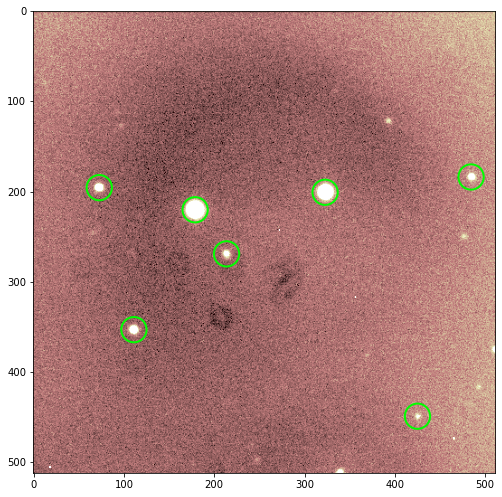

In [213]:
daofind = DAOStarFinder(fwhm=7, threshold=10*std, exclude_border=True)
sources = daofind(image.data)

positions = []
for x,y in zip(sources['xcentroid'],sources['ycentroid']):
    points = [x,y]
    positions.append(points)
    
aperture = CircularAperture(positions, r=14)

# Plotting apertures is easy with photutils aperture objects: just add .plot
plt.figure(figsize = (11,8.5))
plt.imshow(image,norm=znorm,cmap='pink')
aperture.plot(color = 'lime',linewidth = 2);

## Do photometry on those apertures
1. Get total counts in each aperture (aperture_photometry)
2. Format table to look prettier
3. Define the uncalibrated flux from the source

In [215]:
phot = aperture_photometry(image, aperture)
for col in phot.colnames:phot[col].info.format = '%.8g' 
    
source = phot['aperture_sum']
print(phot)

 id  xcenter   ycenter  aperture_sum
       pix       pix        adu     
--- --------- --------- ------------
  1 484.57026 183.70539    1395926.5
  2 72.574526 195.52557      1388105
  3 322.81573 200.67274    2484525.5
  4 178.79459 220.03842      3806985
  5 213.61333 268.88149    1349219.7
  6 110.97824 352.89334    1393117.6
  7 425.17037 448.81709      1371919


## Subtract the local background
1. Define annulus with r_in and r_out (CircularAnnulus)
2. Get total counts in ring around source (aperture_photometry)
3. Divide by area to get average sky/pixel 
4. Scale to get sky noise in just our aperture
5. Subtract the sky from the source to get our final, calibrated fluxes


[ 148446.54094359   66231.80445642 1156221.05634807 2490476.79608796
   27461.11533665   80396.03685255   13606.13915385] adu


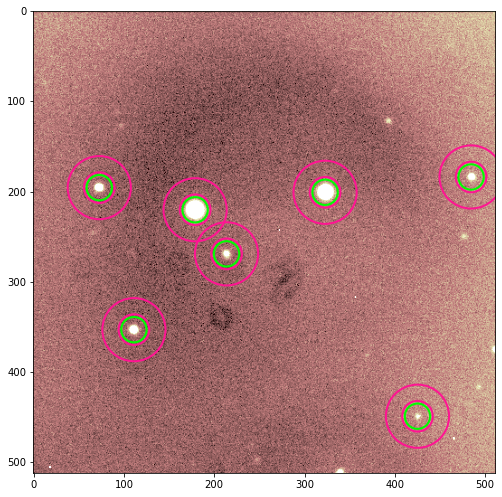

In [221]:
annulus = CircularAnnulus(positions,r_in = 17,r_out = 35)
plt.figure(figsize=(11,8.5))
annulus.plot(color='deeppink',linewidth=2)
aperture.plot(color='lime',linewidth=2)
plt.imshow(image,norm=znorm,cmap='pink');


total_sky = aperture_photometry(image,annulus)['aperture_sum']
avg_sky = total_sky / annulus.area
sky = avg_sky * aperture.area

fluxes = source - sky

print(fluxes);

## Convert fluxes to magnitudes
1. Normalize the fluxes (divide by exposure time)
2. Convert to magnitude system (-2.5logF) 
3. If you want to shift the mags, you can add a constant

In [225]:
exptime = image.header['exposure']

m = -2.5*np.log(np.abs(fluxes.value/exptime))+10
print(m)

# Can also do everything in fewer lines and/or make a function, such as:
def makemag(flux,exptime,C):
    m = C - 2.5 * np.log(np.abs(flux.value/exptime))
    return m
mags = makemag(fluxes,exptime,10)
print(mags)


[-11.26695699  -9.24929669 -16.39867538 -18.31696838  -7.04832228
  -9.73380695  -5.29269749]
[-11.26695699  -9.24929669 -16.39867538 -18.31696838  -7.04832228
  -9.73380695  -5.29269749]
